In [5]:
import torch
import numpy as np
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os
from typing import List, Dict, Any, Tuple, Union

torch.manual_seed(1)
if not os.path.exists(f'{os.path.expanduser("~")}/.cache/huggingface/token'):
    notebook_login()

logging.set_verbosity_error()

torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'

data_root = './data/'
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)
np.set_printoptions(precision=3, linewidth=140)


In [6]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

In [7]:
def pil_to_latent(img):
    img_inp = tfms.ToTensor()(img)[None].to(torch_device) * 2 - 1
    with torch.no_grad():
        latent = vae.encode(img_inp)
    return latent.latent_dist.sample() * 0.18215

def latents_to_pil(latents):
    with torch.no_grad():
        images = vae.decode(latents/0.18215).sample
    images = (images * 0.5 + 0.5).clamp(0, 1)
    images = images.permute(0, 2, 3, 1)
    images = (images.cpu().numpy() * 255).round().astype('uint8')
    image_list = [Image.fromarray(img) for img in images]
    return image_list

def show_latents(latents_org: torch.tensor):
    latents = latents_org.clone()
    if len(latents.shape) == 3:
        latents = latents[None]
    if len(latents.shape) != 4:
        raise ValueError("latents must be of shape (num_latents, num_channels, height, width) or (num_channels, height, width)")
    latents =latents.detach().cpu().numpy()
    N, C, _, _ = latents.shape
    fig, axs = plt.subplots(N, C, figsize=(4*C, 4*N))
    if N == 1:
        axs = axs[None]
    for n in range(N):
        for c in range(C):
            axs[n,c].imshow(latents[n,c], cmap='Greys_r')
            axs[n,c].set_title(f"Latent {n},{c}")
            axs[n,c].axis('off')
    plt.show()

In [8]:
image = Image.open(f'{data_root}/misc_images/horse.png').convert('RGB').resize((512, 512))

(-0.5, 511.5, 511.5, -0.5)

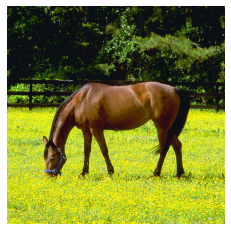

In [9]:
plt.imshow(image)
plt.axis('off')

In [10]:
latents = pil_to_latent(image)
print(latents.shape)
latents.min(), latents.max()

torch.Size([1, 4, 64, 64])


(tensor(-2.857, device='cuda:0'), tensor(2.896, device='cuda:0'))

(-0.5, 511.5, 511.5, -0.5)

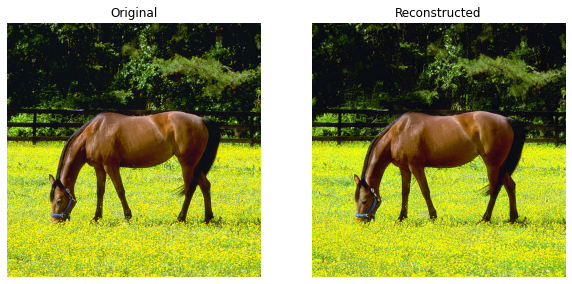

In [11]:
image_decoded = latents_to_pil(latents)[0]
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(image)
ax1.set_title("Original")
ax1.axis('off')
ax2.imshow(image_decoded)
ax2.set_title("Reconstructed")
ax2.axis('off')

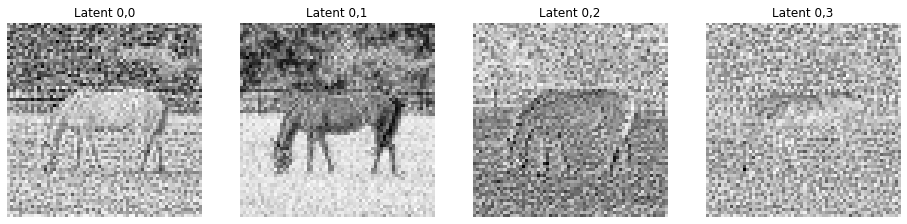

In [12]:
show_latents(latents)

In [13]:
def encode_text(prompts):
    text_input = tokenizer(prompts, padding='max_length', max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    with torch.no_grad():
        text_embed = text_encoder(text_input.input_ids.to(torch_device))[0]
    return text_embed

In [14]:

text_embed = encode_text(["","horse"])
print(text_embed.shape)
print(text_embed[1,2,:10])


torch.Size([2, 77, 768])
tensor([-1.869,  0.054,  0.575, -0.909, -2.028,  1.457, -1.320,  0.123,  0.734,  0.060], device='cuda:0')


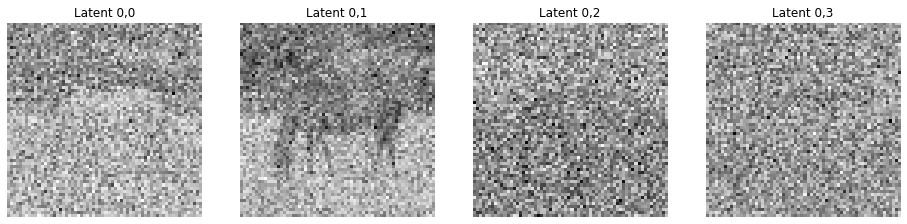

In [15]:
# input_image: image
input_latent = latents
num_timesteps = 50
start_step = 30
scheduler.set_timesteps(num_timesteps)
noise = torch.randn_like(input_latent)
latent_noised = scheduler.add_noise(input_latent, noise, timesteps=torch.tensor([scheduler.timesteps[start_step]]))
show_latents(latent_noised)

In [16]:
prompt = ["a horse", "a zebra"]
text_embeds = encode_text(prompt)

In [17]:
latent_noised_batch = torch.cat([latent_noised]*2)

In [18]:
latent_noised_batch_scaled = scheduler.scale_model_input(latent_noised_batch, scheduler.timesteps[start_step])

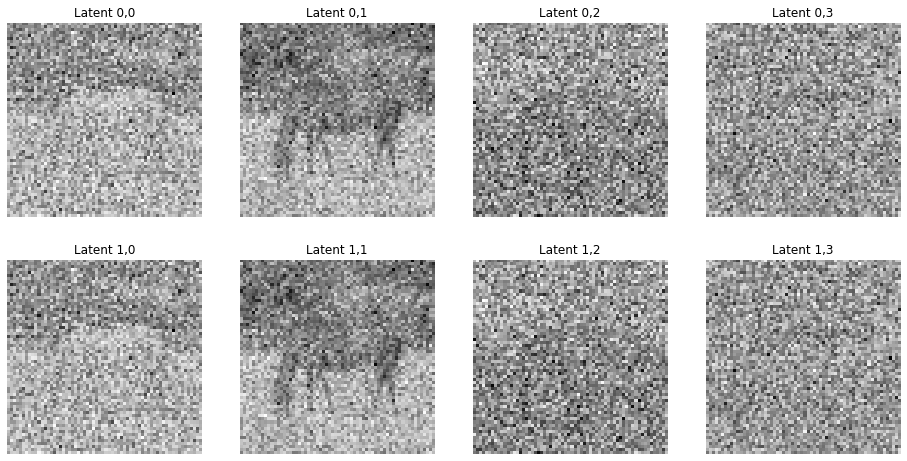

In [19]:
show_latents(latent_noised_batch_scaled)

In [20]:
t = scheduler.timesteps[start_step]
with torch.no_grad():
    noise_pred = unet(latent_noised_batch_scaled, t, encoder_hidden_states=text_embeds)["sample"]

(-0.5, 63.5, 63.5, -0.5)

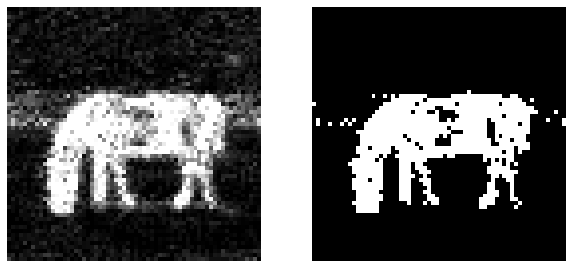

In [21]:
def torch_percentile(T, q):
    k = 1 + round(.01 * float(q) * (T.numel() - 1))
    result = T.view(-1).kthvalue(k).values.item()
    return result

outlier_percentile = 10
org, new = noise_pred.chunk(2)
org = org[0,...]
new = new[0,...]
diff = (org - new).abs().sum(dim=0)
outlier_max = torch_percentile(diff, 100 - outlier_percentile)
outlier_min = torch_percentile(diff, outlier_percentile)
diff = diff.clamp(outlier_min, outlier_max)
diff = (diff - diff.min()) / (diff.max() - diff.min())
diff_binary = (diff > 0.5).float()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(diff.cpu().numpy(), cmap='Greys_r')
ax1.axis('off')
ax2.imshow(diff_binary.cpu().numpy(), cmap='Greys_r')
ax2.axis('off')

In [22]:
def get_diffedit_mask(image: Union[Image.Image, str], prompts: List[str],  start_step: int = 30, 
    num_timesteps: int = 50, outlier_percentile: int = 10, num_iterations: int = 10) -> Union[np.ndarray, torch.tensor]:
    if isinstance(image, str):
        image = Image.open(image).convert('RGB').resize((512, 512))
    else:
        image = image.resize((512, 512))
    latents = pil_to_latent(image)
    text_embeds = encode_text(prompts)
    scheduler.set_timesteps(num_timesteps)
    time_start_step = scheduler.timesteps[start_step]
    masks = []
    for iterid in range(num_iterations):
        noise = torch.randn_like(latents)
        latent_noised = scheduler.add_noise(latents, noise, timesteps=torch.tensor([time_start_step]))
        latent_noised_batch = torch.cat([latent_noised]*len(prompts))
        latent_noised_batch_scaled = scheduler.scale_model_input(latent_noised_batch, time_start_step)
        with torch.no_grad():
            noise_pred = unet(latent_noised_batch_scaled, time_start_step, encoder_hidden_states=text_embeds)["sample"]
        org, new = noise_pred.chunk(2)
        org = org[0,...]
        new = new[0,...]
        diff = (org - new).abs().sum(dim=0)
        outlier_max = torch_percentile(diff, 100 - outlier_percentile)
        outlier_min = torch_percentile(diff, outlier_percentile)
        diff = diff.clamp(outlier_min, outlier_max)
        diff = (diff - diff.min()) / (diff.max() - diff.min())
        masks.append(diff[None])
    diff_avg = torch.cat(masks).mean(dim=0)
    diff_binary = (diff_avg > 0.5).float()
    return diff_binary

(-0.5, 63.5, 63.5, -0.5)

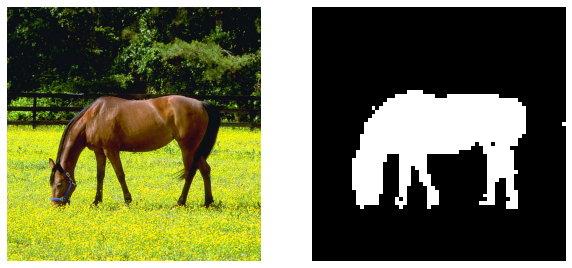

In [23]:
mask = get_diffedit_mask(image, ["a horse", "a zebra"], start_step=30, num_timesteps=50, outlier_percentile=10, num_iterations=10)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(image)
ax2.imshow(mask.cpu().numpy(), cmap='Greys_r')
ax1.axis('off')
ax2.axis('off')

In [24]:
start_step = 20
num_timesteps = 50
guidance = 7.5
prompts = ["", "a zebra"]

text_embeds = encode_text(prompts)
latents = pil_to_latent(image)
scheduler.set_timesteps(num_timesteps)
time_start_step = scheduler.timesteps[start_step]
latents_curr = scheduler.add_noise(latents, torch.randn_like(latents), timesteps=torch.tensor([time_start_step]))

# show_latents(latents_curr)
for step_id in range(start_step, num_timesteps):
    t = scheduler.timesteps[step_id]
    latents_curr_batch = torch.cat([latents_curr]*len(prompts))
    latents_curr_batch_scaled = scheduler.scale_model_input(latents_curr_batch, t)
    with torch.no_grad():
        noise_pred = unet(latents_curr_batch_scaled, t, encoder_hidden_states=text_embeds)["sample"]
    u_pred, t_pred  = noise_pred.chunk(2)
    t_pred = u_pred + guidance * (t_pred - u_pred)
    latents_curr = scheduler.step(t_pred, t, latents_curr).prev_sample
    if step_id < num_timesteps - 1:
        t_minus_1 = scheduler.timesteps[step_id + 1]
        latents_org = scheduler.add_noise(latents, torch.randn_like(latents), timesteps=torch.tensor([t_minus_1]))
        latents_curr = mask * latents_curr + (1 - mask) * latents_org



(-0.5, 63.5, 63.5, -0.5)

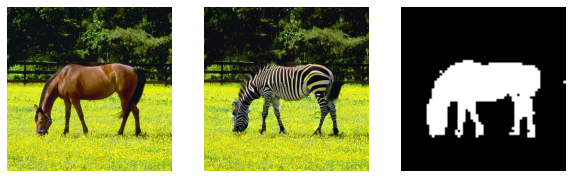

In [25]:
#latents_curr = latents_curr * mask.float()*1.0# + latents * (1 - mask)
image_transformed = latents_to_pil(latents_curr)[0]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
ax1.imshow(image)
ax2.imshow(image_transformed)
ax3.imshow(mask.cpu().numpy(), cmap='Greys_r')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')

In [26]:
def get_diffedit_image(image: Image.Image, mask: torch.tensor, prompts: List[str], start_step: int = 20, num_timesteps: int = 50, guidance: float = 7.5) -> Image.Image:
    text_embeds = encode_text(prompts)
    latents = pil_to_latent(image)
    scheduler.set_timesteps(num_timesteps)
    time_start_step = scheduler.timesteps[start_step]
    latents_curr = scheduler.add_noise(latents, torch.randn_like(latents), timesteps=torch.tensor([time_start_step]))
    for step_id in range(start_step, num_timesteps):
        t = scheduler.timesteps[step_id]
        latents_curr_batch = torch.cat([latents_curr]*len(prompts))
        latents_curr_batch_scaled = scheduler.scale_model_input(latents_curr_batch, t)
        with torch.no_grad():
            noise_pred = unet(latents_curr_batch_scaled, t, encoder_hidden_states=text_embeds)["sample"]
        u_pred, t_pred  = noise_pred.chunk(2)
        t_pred = u_pred + guidance * (t_pred - u_pred)
        latents_curr = scheduler.step(t_pred, t, latents_curr).prev_sample
        if step_id < num_timesteps - 1:
            t_minus_1 = scheduler.timesteps[step_id + 1]
            latents_org = scheduler.add_noise(latents, torch.randn_like(latents), timesteps=torch.tensor([t_minus_1]))
            latents_curr = mask * latents_curr + (1 - mask) * latents_org
    image_transformed = latents_to_pil(latents_curr)[0]
    return image_transformed

In [27]:
image_transformed = get_diffedit_image(image, mask, ["", "a zebra"], start_step=20, num_timesteps=50, guidance=7.5)

(-0.5, 511.5, 511.5, -0.5)

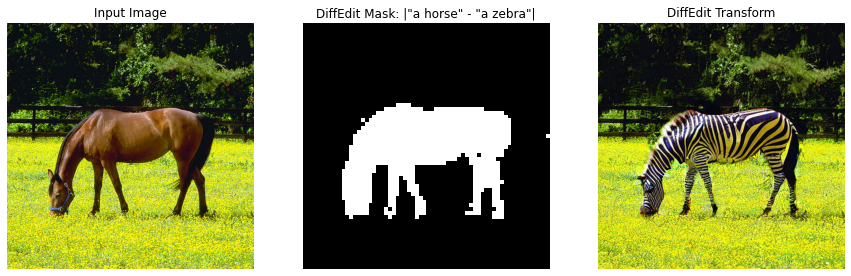

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.imshow(image); ax1.set_title("Input Image")
ax2.imshow(mask.cpu().numpy(), cmap='Greys_r'); ax2.set_title("DiffEdit Mask: |\"a horse\" - \"a zebra\"|")
ax3.imshow(image_transformed); ax3.set_title("DiffEdit Transform")
ax1.axis('off'); ax2.axis('off'); ax3.axis('off')